In [14]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../")

import numpy as np
from tensorflow import keras
from oodeel.models.load_utils import get_model
from oodeel.methods.mls import MLS
from oodeel.methods.dknn import DKNN
import tensorflow as tf
import matplotlib.pyplot as plt

from oodeel.datasets.load_utils import keras_dataset_load
from oodeel.eval.metrics import bench_metrics, get_curve
from oodeel.datasets.data_handler import DataHandler


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Two datasets experiment

In [2]:
#### MNIST
# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras_dataset_load("mnist")
#### Fashion MNIST

# Load the data and split it between train and test sets
_ , (x_ood, y_ood) = keras_dataset_load("fashion_mnist")

model = get_model("../saved_models/mnist_model")

2022-09-20 17:06:24.316043: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-20 17:06:24.316997: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 17:06:24.317765: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (B20212474): /proc/driver/nvidia/version does not exist
2022-09-20 17:06:24.328770: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### MLS

0.9947957849999999


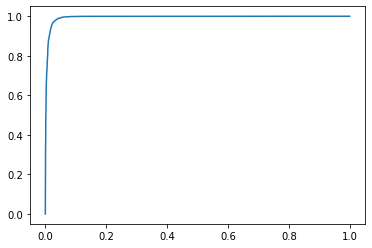

In [8]:

%autoreload 2

oodmodel = MLS(output_activations=["linear"])
oodmodel.fit(model)
scores_id, scores_ood = oodmodel.score([x_test, x_ood])

#TODO dataset handler to obtain labels
scores = np.concatenate([scores_id, scores_ood]) #ood has to be higher
labels = np.concatenate([np.zeros(scores_id.shape), np.ones(scores_ood.shape)])

fpr, tpr = get_curve(scores, labels)
(auroc) = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()

### DKNN

0.791859


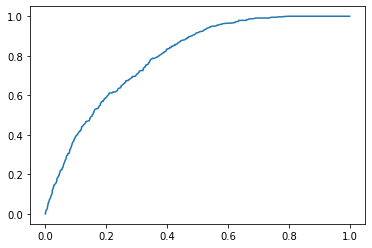

In [11]:
%autoreload 2

## This time need a dataset to fit KNN score
(x_train, y_train), (x_test, y_test) = keras_dataset_load("mnist")

oodmodel = DKNN()
oodmodel.fit(model, x_train[:10000])
scores_id, scores_ood = oodmodel.score([x_test[:1000], x_ood[:1000]])

scores = np.concatenate([scores_id, scores_ood]) #ood has to be higher
labels = np.concatenate([np.zeros(scores_id.shape), np.ones(scores_ood.shape)])

fpr, tpr = get_curve(scores, labels)
(auroc) = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()

## Single dataset experiment

(Leave-$k$-classes-out training).
First, we need to define a training function

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

#### ATTENTION A NUM CLASSES QUE CE SOIT BIEN len(split) ET QUE ONE HOT ENC SOIT BIEN
def training_mnist(train_data, config=None):
    x_train, y_train = train_data
    input_shape = (28, 28, 1)
    num_classes=np.unique(y_train).shape[0]

    y_train = keras.utils.to_categorical(y_train, num_classes)

    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )

    batch_size = 128
    epochs = 5

    # compile and fit
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)    

    return model


In [15]:
(x_train, y_train), (x_test, y_test) = keras_dataset_load("mnist")

inc_labels = [0, 1, 2, 3, 4]

mnist_train = DataHandler(x_train, y_train)
mnist_test = DataHandler(x_test, y_test)

x_id_train, y_id_train = mnist_train.filter(inc_labels=inc_labels) 

x_id_test, _ = mnist_test.filter(inc_labels=inc_labels) 
x_ood_test, _ = mnist_test.filter(excl_labels=inc_labels) 

train_data = (x_id_train, y_id_train)
model = training_mnist(train_data)

Epoch 1/5
216/216 [==============================] - 10s 38ms/step - loss: 0.2595 - accuracy: 0.9192 - val_loss: 0.0462 - val_accuracy: 0.9863
Epoch 2/5
216/216 [==============================] - 7s 35ms/step - loss: 0.0601 - accuracy: 0.9814 - val_loss: 0.0306 - val_accuracy: 0.9918
Epoch 3/5
216/216 [==============================] - 8s 35ms/step - loss: 0.0433 - accuracy: 0.9864 - val_loss: 0.0282 - val_accuracy: 0.9928
Epoch 4/5
216/216 [==============================] - 8s 36ms/step - loss: 0.0333 - accuracy: 0.9890 - val_loss: 0.0194 - val_accuracy: 0.9954
Epoch 5/5
216/216 [==============================] - 7s 35ms/step - loss: 0.0299 - accuracy: 0.9906 - val_loss: 0.0206 - val_accuracy: 0.9958


## MLS

0.9260736667726286


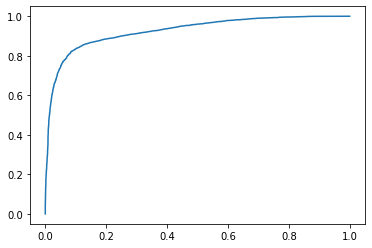

In [17]:
%autoreload 2

oodmodel = MLS(output_activations=["linear"])
oodmodel.fit(model)
scores_id, scores_ood = oodmodel.score([x_id_test, x_ood_test])

#TODO dataset handler to obtain labels
scores = np.concatenate([scores_id, scores_ood]) #ood has to be higher
labels = np.concatenate([np.zeros(scores_id.shape), np.ones(scores_ood.shape)])

fpr, tpr = get_curve(scores, labels)
(auroc) = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()

### DKNN

0.9308345000000001


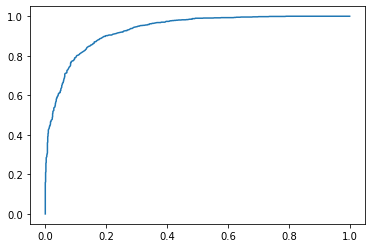

In [19]:
%autoreload 2

oodmodel = DKNN()
oodmodel.fit(model, x_id_train[:10000])
scores_id, scores_ood = oodmodel.score([x_id_test[:1000], x_ood_test[:1000]])

scores = np.concatenate([scores_id, scores_ood]) #ood has to be higher
labels = np.concatenate([np.zeros(scores_id.shape), np.ones(scores_ood.shape)])

fpr, tpr = get_curve(scores, labels)
(auroc) = bench_metrics(scores, labels)

print(auroc)
plt.plot(fpr, tpr)
plt.show()